#**Previsione dell'affidabilità creditizia per il rilascio della carta di credito**#

Questo progetto realizzato da me, Alessio Feudo, nell'ambito del master in Data Science erogato da Profession IA, tratta la realizzazione di un modello di machine learning in grado di prevedere l'affidabilità creditizia dei clienti di una banca classificandoli come idonei o non per il rilascio della carta di credito. Il modello si baserà su un dataset contenente i dati anonimi di clienti che hanno già ottenuto la carta di credito e ne pagano regolarmente le tasse. Per risolvere questo compito saranno valutati due modelli diversi. Un decision tree come modello di fiducia, essendo anche semplice da interpretare nel risultato, dando così la possibilità alla banca di giustificare al cliente perchè non si accetta la sua richiesta di credito. Oltre a questo modello, si testa la sua diretta generalizzazione, cioè una random forest, che ne migliora le proprietà generali mettendo insieme i risultati di più alberi, pur perdendo di interpretabilità. In tal senso la random forest si testa solo per valutare di quanto le previsioni sarebbero più o meno corrette rispetto al singolo albero.

Il dataset fornito contiene le seguenti variabili:

*   ID: numero identificativo del cliente
*    CODE_GENDER: sesso del cliente
*    FLAG_OWN_CAR: indicatore del possesso di un'automobile
*    FLAG_OWN_REALTY: indicatore del possesso di una casa
*    CNT_CHILDREN: numero di figli
*    AMT_INCOME_TOTAL: reddito annuale
*    NAME_INCOME_TYPE: tipo di reddito
*    NAME_EDUCATION_TYPE: livello di educazione
*    NAME_FAMILY_STATUS: stato civile
*    NAME_HOUSING_TYPE: tipo di abitazione
*    DAYS_BIRTH: numero di giorni trascorsi dalla nascita
*    DAYS_EMPLOYED: numero di giorni trascorsi dalla data di assunzione (se positivo, indica il numero di giorni da quando è disoccupato)
*    FLAG_MOBIL: indicatore della presenza di un numero di cellulare
*    FLAG_WORK_PHONE: indicatore della presenza di un numero di telefono di lavoro
*    FLAG_PHONE: indicatore della presenza di un numero di telefono
*    FLAG_EMAIL: indicatore della presenza di un indirizzo email
*    OCCUPATION_TYPE: tipo di occupazione
*    CNT_FAM_MEMBERS: numero di familiari
*    TARGET: variabile che vale 1 se il cliente ha una elevata affidabilità creditizia (pagamento costante delle rate), 0 altrimenti.


In [ ]:
import pandas as pd
from scipy.stats import kurtosis, skew
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, RocCurveDisplay, log_loss

In [ ]:
df_ini=pd.read_csv('https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv')
df_ini=df_ini.drop('ID', axis=1) # id drop

## **1-Analisi dataset training** ##
### **1.1-Suddivisione dataset** ###
Come primo passo si divide il dataset in train/validation/test sets, assegnando il 70% al train, il 10% al validation e il 20% al test. La suddivisione preventiva serve per condurre le analisi statistiche solo sul train, così da non cadere nel 'data leakage' che si instaurerebbe andando a vedere anche i dati di validation e/o test, che invece devono restare sconosciuti al modello, affinchè si possano valutare le sue prestazioni su dati completamente nuovi, simulando così le effettive capacità predittive finali del modello.

In [ ]:
#create dataframe copy
df=df_ini.copy()

print(df)
print(df.info(),'\n')

#split train, validation, test
x=df.drop('TARGET', axis=1)
y=df['TARGET']
#splitting: 70% train, 10% val and 20% test.
x_train_tot, x_test, y_train_tot, y_test = train_test_split(x,y, test_size=0.2, stratify=y, random_state=2, shuffle=True) #stratify in order to preserve target label distribution
x_train_partial, x_val, y_train_partial, y_val = train_test_split(x_train_tot, y_train_tot, test_size=0.125, shuffle=True, stratify=y_train_tot, random_state=2)

#train subdataframe
df_train=pd.concat([x_train_partial, y_train_partial], axis=1)
df_val=pd.concat([x_val, y_val], axis=1)
print(f"\nLa dimensione del df di train è di: {df_train.shape[0]}\n")

       CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0                M            Y               Y             0   
1                M            Y               Y             0   
2                M            Y               Y             0   
3                F            N               Y             0   
4                F            N               Y             0   
...            ...          ...             ...           ...   
338422           F            N               Y             0   
338423           F            N               Y             0   
338424           F            N               Y             0   
338425           F            N               Y             0   
338426           F            N               N             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              424380.57               Working               Higher education   
1              421593.52               Working           

In [ ]:
def features_insight(df, num_var, qual_var):
  '''
  The function analyzes numerical and categorical features of a given dataframe.

  Args:
      - df (pd dataframe): the dataframe to analyze
      - num_var (list of strings): list of numerical features
      - qual_var (list of strings): list of categorical features
  '''
  #numerical features distributions
  for var in num_var:
      print(df[var].describe())
      if var=='AMT_INCOME_TOTAL':
          print(f"Skewness: {skew(df[var]):.3f}\nkurtosis: {kurtosis(df[var]):.3f}\n\n")
      else:
          print('\n\n')

  #counts and classes categorical features
  for var in qual_var:
      print(df[var].value_counts(),'\n')





def feature_engineering(df_train, num_var, qual_var, df_test=None, verbose=False, fillna=False):
    '''
    This function accounts for data correction and modification, fitting corrections on the train set and applying the same to the test set.

    Args:
        - df_train (pd dataframe): train set dataframe
        - num_var (list): numerical features
        - qual_var (list): categorical features
        - df_test (pd dataframe): test set dataframe. Default: None
        - verbose (bool): enables the verbose mode. Default: False
        - fillna (bool): missing data imputation

    Returns:
        - pd dataframe: processed train set dataframe
        - pd dataframe: processed test set dataframe
    '''

    #nan data imputation
    for var in num_var:
        if df_train[var].isna().sum()!=0 and fillna==True:
            mean_val_train=df_train[var].mean() #mean imputation (train set computed)
            df_train[var]=df_train[var].fillna(mean_val_train)
            if df_test is not None:
                df_test[var]=df_test[var].fillna(mean_val_train)

    for var in qual_var:
        if df_train[var].isna().sum()!=0 and var!='OCCUPATION_TYPE' and fillna==True: #occupation_type will be corrected individually
            mode_val_train=df_train[var].mode()[0] #mode imputation (train set computed)
            df_train[var]=df_train[var].fillna(mode_val_train)
            if df_test is not None:
                df_test[var]=df_test[var].fillna(mode_val_train)

    #'OCCUPATION_TYPE' contains many nans linked to working states where no info is needed, but only NAME_INCOME_TYPE is sufficient.
    #A new class is built to store them.
    df_train['OCCUPATION_TYPE']=df_train['OCCUPATION_TYPE'].fillna('Not specified')
    if df_test is not None:
        df_test['OCCUPATION_TYPE']=df_test['OCCUPATION_TYPE'].fillna('Not specified')

    #DAYS_BIRTH transformed to positive years
    df_train['DAYS_BIRTH']=-df_train['DAYS_BIRTH']/365
    if df_test is not None:
        df_test['DAYS_BIRTH']=-df_test['DAYS_BIRTH']/365

    #DAYS_EMPLOYED class creation
    df_train['DAYS_EMPLOYED']=-df_train['DAYS_EMPLOYED']/365 #change sign and year extraction
    if df_test is not None:
        df_test['DAYS_EMPLOYED']=-df_test['DAYS_EMPLOYED']/365

    class_split = [-2000, -10, 0, 10, 20, 30, 40, 70]
    class_labels = ['Unemployed/Pensioner','Unemployed', 'Junior', 'Medium','Senior_low','Senior_high','Veteran'] #working experience class creation
    df_train['DAYS_EMPLOYED'] = pd.cut(df_train['DAYS_EMPLOYED'], bins=class_split, labels=class_labels)
    if df_test is not None:
        df_test['DAYS_EMPLOYED'] = pd.cut(df_test['DAYS_EMPLOYED'], bins=class_split, labels=class_labels)

    #check for successfull class creation
    if df_train['DAYS_EMPLOYED'].isna().sum()==0 and ((df_test is not None and df_test['DAYS_EMPLOYED'].isna().sum()==0) or df_test is None):
        print('Non ci sono nan rimasti fuori dalle classi di DAYS_EMPLOYED\n')
    elif df_train['DAYS_EMPLOYED'].isna().sum()!=0 and (df_test is None or df_test['DAYS_EMPLOYED'].isna().sum()==0):
        print('Ci sono nan rimasti fuori dalle classi di DAYS_EMPLOYED per train e sono: \n',df_train[df_train['DAYS_EMPLOYED'].isna()])
    elif df_train['DAYS_EMPLOYED'].isna().sum()==0 and df_test is not None and df_test['DAYS_EMPLOYED'].isna().sum()!=0:
        print('Ci sono nan rimasti fuori dalle classi di DAYS_EMPLOYED per test e sono: \n',df_test[df_test['DAYS_EMPLOYED'].isna()])
    else:
        print('Ci sono nan rimasti fuori dalle classi di DAYS_EMPLOYED, per train e test e sono: \n',df_train[df_train['DAYS_EMPLOYED'].isna()],'\nper test sono: \n', df_test[df_test['DAYS_EMPLOYED'].isna()])


    #binary categorical features encoded via Label encoding
    yes_no_var=['FLAG_OWN_CAR','FLAG_OWN_REALTY'] #features to encode
    yes_no_map={'Y':1, 'N':0}
    for var in yes_no_var:
        df_train[var]=df_train[var].map(yes_no_map)
        if df_test is not None:
            df_test[var]=df_test[var].map(yes_no_map)
    if verbose==True:
         print(f"\nDATAFRAME TRAIN FINALE\n\n{df_train}")

    return df_train, df_test


###############################################   MAIN   ############################################


#features grouped by continue numerical features and discrete/categorical features
num_var=['AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED']
qual_var=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FLAG_MOBIL',
          'FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE','CNT_FAM_MEMBERS','TARGET']

#nans analysis
print(f"Analisi valori non idonei\n{df_train.isna().sum()}\n")



#features analysis (only on train set)
features_insight(df_train, num_var, qual_var)

#conditional analysis of 'occupation type', to further investigate nans
print('\nANALISI CONDIZIONATA SU OCCUPATION_TYPE\n')
df_occupation=df_train[df_train['OCCUPATION_TYPE'].isna()]
print(df_occupation)


#DAYS_EMPLOYED analysis
print('\nANALISI DAYS_EMPLOYED\n')
print(df_train[df_train['DAYS_EMPLOYED']>=0]) #print dataframe conditioned to unemployment status
print('Il numero di samples con disoccupazione è: ',(df_train['DAYS_EMPLOYED']>=0).sum()) #tot unemployed
print(f"Il minimo per i valori di disoccupazione è: {df_train.loc[df_train['DAYS_EMPLOYED']>0,'DAYS_EMPLOYED'].min():.3f}\n") #minimum of unemployment days

#nan imputation, specific analysis of certain features, label encodig
df_train, df_val=feature_engineering(df_train, num_var, qual_var, df_test=df_val, verbose=True, fillna=True)
features_insight(df_train, num_var, qual_var)




Analisi valori non idonei
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         1
NAME_HOUSING_TYPE          1
DAYS_BIRTH                 1
DAYS_EMPLOYED              1
FLAG_MOBIL                 1
FLAG_WORK_PHONE            1
FLAG_PHONE                 1
FLAG_EMAIL                 1
OCCUPATION_TYPE        72359
CNT_FAM_MEMBERS            1
TARGET                     0
dtype: int64

count    2.368980e+05
mean     1.878137e+05
std      1.099081e+05
min      2.554898e+04
25%      1.214918e+05
50%      1.630652e+05
75%      2.252612e+05
max      6.807256e+06
Name: AMT_INCOME_TOTAL, dtype: float64
Skewness: 8.477
kurtosis: 297.697


count    236897.000000
mean     -15994.981279
std        4189.485522
min      -26636.000000
25%      -19455.000000
50%      -15619.000000
75%      -12520.000000
max       -7566.000000
Nam

###**1.2-Analisi descrittiva**###

Il dataset contiene 18 varibili, di cui una target, che rappresenta l'affidabilità creditizia del cliente. Per iniziare si studiano le varie variabili del dataset, divise per numeriche continue (anche se espresse in discreto) e numeriche discrete/qualitative. Per le numeriche continue si ha:
* AMT_INCOME_TOTAL: Mostra una distribuzione asimmetrica positiva con presenza di outliers verso alti valori del reddito. Inoltre anche la curtosi è positiva, indicando che il picco è più pronunciato di quello di una gaussiana.
* DAYS_BIRTH: Mostra una distribuzione di età con età minima 21 anni ed età massima 73 anni. Dai valori di media e mediana simili, la distribuzione risulta abbastanza simmetrica rispetto alla media di circa 44 anni, con il 75% dei clienti con età tra 34 e 53 anni.
* DAYS_EMPLOYED: Si nota che il massimo si ha per 49 anni di impiego, mentre per la disoccupazione si trova (dal valore massimo nominale della variabile) il valore mal registrato, o comunque da interpretare, di 1073 anni di disoccupazione. Si attua quindi una divisione in classi lavorative, andando a creare anche un'opportuna classe per le disoccupazioni troppo elevate, interpretandole come pesionati.

Per le numeriche discrete/qualitative invece:
* CODE_GENDER: le femmine sono circa il doppio dei maschi.
* FLAG_OWN_CAR: i non possidenti di auto sono circa il doppio dei possidenti.
* FLAG_OWN_REALTY: i possidenti di abitazione sono circa il doppio rispetto a chi non ne possiede una.
* CNT_CHILDREN: più del doppio dei clienti non ha figli.
* NAME_INCOME_TYPE: circa la metà dei clienti dichiara un reddito di tipo 'working', seguito da una buona percentuale di redditi 'Commercial associate' e 'Pensioner'.
* NAME_EDUCATION_TYPE: i due terzi dei clienti detiene un grado di istruzione 'Secondary / secondary special'.
* NAME_FAMILY_STATUS: i clienti riportano per i due terzi lo stato di sposati.
* NAME_HOUSING_TYPE: la quasi totalità dei clienti vive in case/appartamenti.
* FLAG_MOBIL: tutti hanno associato un numero di cellulare.
* FLAG_WORK_PHONE: più dei due teri dei clienti non ha un cellualre di lavoro.
* FLAG_PHONE: più dei due terzi dei clienti non ha un numero di telefono associato.
* FLAG_EMAIL: la quasi totalita dei clienti non ha un indirizzo mail.
* OCCUPATION_TYPE: circa un terzo dei clienti non specifica il preciso lavoro cui è addetto. Come unica informazione lavorativa riportano la fonte di reddito precedentemente analizzata. Per i clienti che non specificano il tipo di occupazione si crea una nuova classe 'Not specified'.
* CNT_FAM_MEMBERS: poco più della metà dei clienti si trova in un nucleo familiare di due persone, seguito da una buona quota di single/vedovi.
* TARGET: la variabile target che identifica se avendo concesso la carta di credito il cliente sia in regola con le rate o meno, è sbilanciata in favore della classe negativa che rappresenta quasi la totalità dei clienti. Solo una minima parte risulta quindi affidabile a livello creditizio. Questo sbilanciamento sarà adeguatamente trattato nel modello.

### **1.3-Feature engineering**###
Per preparare il dataset ad essere usato dal modello di ML si procede con l'encoding di alcune features. Le variabili 'CODE_GENDER','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE' e 'DAYS_EMPLOYED' verranno codificate tramite one hot encoding nella sezione subito precedente alla creazione del modello. Intanto le variabili 'FLAG_OWN_CAR','FLAG_OWN_REALTY' vengono semplicemente codificate in 1 e 0 invece degli originali Y e N. La variabile 'DAYS_EMPLOYED' viene trasformata in anni di servizio (cambio di segno), poi vengono create fasce di anni di servizio/pesnionamento associandole a nomi esaustivi inerenti all'esperienza lavorativa. Queste classi sono utili anche per incamerare i valori di giorni di disoccupazione che risultano particolamente anomali ed elevati.
Anche la variabile 'DAYS_BIRTH' viene trasfomrata in anni positivi che rappresentano direttamente l'età del cliente.


### **1.4-Correlazioni tra le features e il target**###

Come ulteriore analisi preliminare si procede a visionare la matrice di correlazione per le variabili numeriche e target, dove come indicatore si sceglie di usare la correlazione di Spearman perchè più generale e adatta anche per relazioni non lineari.
Per studiare il legame tra variabili qualitative nominali e target si usa invece il test del Chi quadro che valuta la dipendenza tra le variabili analizzate.


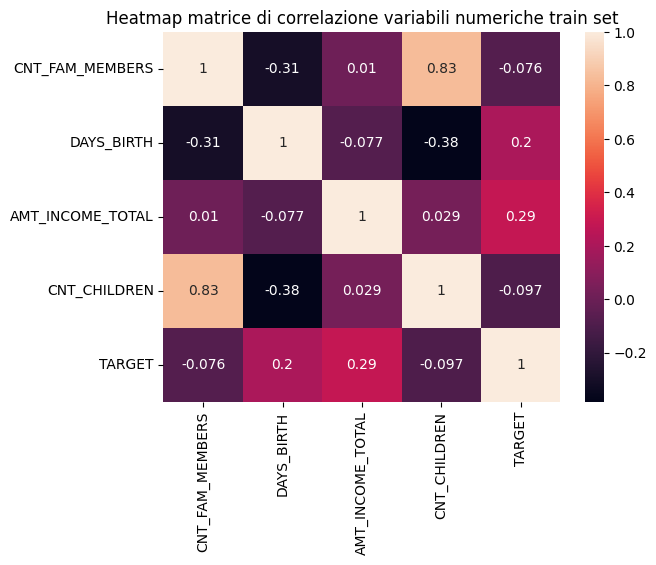


TEST DEL CHI QUADRO VAR NOMINALI E TARGET

CODE_GENDER
p_value test chi_quadro: 1.041e-11
Si rifiuta ipotesi di indipendenza tra la variabile CODE_GENDER e il target.

FLAG_OWN_CAR
p_value test chi_quadro: 3.611e-59
Si rifiuta ipotesi di indipendenza tra la variabile FLAG_OWN_CAR e il target.

FLAG_OWN_REALTY
p_value test chi_quadro: 4.914e-47
Si rifiuta ipotesi di indipendenza tra la variabile FLAG_OWN_REALTY e il target.

NAME_INCOME_TYPE
p_value test chi_quadro: 0.000e+00
Si rifiuta ipotesi di indipendenza tra la variabile NAME_INCOME_TYPE e il target.

NAME_EDUCATION_TYPE
p_value test chi_quadro: 1.503e-97
Si rifiuta ipotesi di indipendenza tra la variabile NAME_EDUCATION_TYPE e il target.

NAME_FAMILY_STATUS
p_value test chi_quadro: 1.942e-74
Si rifiuta ipotesi di indipendenza tra la variabile NAME_FAMILY_STATUS e il target.

NAME_HOUSING_TYPE
p_value test chi_quadro: 1.432e-147
Si rifiuta ipotesi di indipendenza tra la variabile NAME_HOUSING_TYPE e il target.

FLAG_MOBIL
p_value

In [ ]:
#numerical features VS target correlation matrix heatmap
df_train_num=df_train[['CNT_FAM_MEMBERS','DAYS_BIRTH','AMT_INCOME_TOTAL','CNT_CHILDREN','TARGET']]
cor=df_train_num.corr(method='spearman')
sns.heatmap(cor, annot=True)
plt.title('Heatmap matrice di correlazione variabili numeriche train set')
plt.show()

#Categorigal features VS target Chi squared test
nominal_var=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FLAG_MOBIL',
          'FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE']
print("\nTEST DEL CHI QUADRO VAR NOMINALI E TARGET\n")
for var in nominal_var:
    contingency_tab=pd.crosstab(df_train[var], df_train['TARGET'])
    _, p_val, _, _ = chi2_contingency(contingency_tab) #p-value
    print(f"{var}\np_value test chi_quadro: {p_val:.3e}")

    if p_val>=0.05: #p-value>= 0.05: independency hp preserved
       print(f"Non si rifiuta ipotesi di indipendenza tra la variabile {var} e il target.\n")
    else:
       print(f"Si rifiuta ipotesi di indipendenza tra la variabile {var} e il target.\n")

Dallo studio delle correlazioni tra variabili numeriche e target si riscontra come età del cliente e reddito annuale siano le più signifative. Si notano anche correlazioni tra le features stesse, specie tra numero di figli e  numero di familiari, dato che la seconda ingloba anche la prima. Ulteriori correlazioni si riscontrano tra l'età del cliente e il numero di figli/familiari.

Per quanto riguarda le variabili qualitative nominali, si è valutato il grado di influenza sul target tramite un test di indipendenza del Chi-quadro. L'ipotesi nulla è quella di variabili indipendenti. Un p-value minore del livello di errore posto a 0.05 indica evidenza per rifiutare l'ipotesi nulla, portando a variabili dipendenti. Si nota come il target mostri dipendenza da tutte le variabili considerate, tranne 'FLAG_MOBIL', co cui non c'è legame. Qeusto in realtà si deduce dal fatto che la totalità dei clienti esaminati nel set di training possiede un cellulare, per cui non essendoci variabilità in questa proprietà, il suo contributo non è informativo, in quanto uguale per tutti. Si lascia comunque questa varibile nel modello finale perchè nulla si sa a priori sui clienti del set di validation o test.



###**1.5-One Hot Encoding**###

Una volta analizzati i legami tra le features e il target si passa a codificare tramite One Hot Encoding le variabili qualitative nominali, così da passare poi al modello.

In [ ]:
#one hot encoding
df_train=pd.get_dummies(df_train, columns=['CODE_GENDER','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','DAYS_EMPLOYED'])
df_val=pd.get_dummies(df_val, columns=['CODE_GENDER','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','DAYS_EMPLOYED'])

#inserting 0 when feature columns are present in train but not in val set
df_val = df_val.reindex(columns=df_train.columns, fill_value=0)

print(df_train.info())


<class 'pandas.core.frame.DataFrame'>
Index: 236898 entries, 74822 to 224484
Data columns (total 61 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   FLAG_OWN_CAR                                       236898 non-null  int64  
 1   FLAG_OWN_REALTY                                    236898 non-null  int64  
 2   CNT_CHILDREN                                       236898 non-null  int64  
 3   AMT_INCOME_TOTAL                                   236898 non-null  float64
 4   DAYS_BIRTH                                         236898 non-null  float64
 5   FLAG_MOBIL                                         236898 non-null  float64
 6   FLAG_WORK_PHONE                                    236898 non-null  float64
 7   FLAG_PHONE                                         236898 non-null  float64
 8   FLAG_EMAIL                                         236898 non-null  float64

## **2-Creazione Modelli Predittivi**
###**2.1-Ricerca iperparametri**
Dopo aver analizzato il set di training, si costruisce il modello predittivo in grado di prevedere l'affidabilità creditizia. Si terrà in conto anche lo sbilanciamento delle classi del target, usando un class_weight nell'addestramento del modello, andando ad assegnare un peso maggiore alla classe minoritaria a livello di funzione di costo del modello. Dato il tipo di dataset a disposizione, avente sia molti samples che molte features, si sceglie di utilizzare un albero decisionale, che garantisce anche una buona interpretabilità dei risultati. Per confronto puramente di performance si testerà poi anche una random forest.
Per i modelli basati su alberi non serve standardizzare/normalizzare i dati perchè non sono modelli basati sulla distanza. Per selezionare il miglior modello in termini di f1-score, che bilancia precisione (percentuale di predizioni positive corrette) e recall (percentuale di veri positivi identificati), si attua una valutazione di diverse varianti dello stesso modello, variando gli iperparametri principali.

In [ ]:
def confusion(y_true, y_pred, name):
  '''
   This function shows the confusion matrix of the model.
   Args:
       - y_true (np.array): true target
       - y_pred (np.array): predicted target
       - name (str): string to insert in the plot title
  '''
  cm=confusion_matrix(y_true, y_pred)
  #confusion matrix as dataframe
  df_cm=pd.DataFrame(cm, index=['True Negative','True Positive'], columns=['Predicted Negative','Predicted Positive'])
  # confusion matrix heatmap
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title(f"CONFUSION MATRIX-{name}")
  plt.show()


def evaluate_model(x_train, y_train, x_test, y_test, model, thresh=0.50):
  '''
  The function evaluates the input model through many classification metrics.
  Args:
      - x_train (np.array): train samples
      - y_train (np.array): train true target
      - x_test (np.array): test smaples
      - y_test (np.array): test true target
      - model (obj): model to evaluate
      - thresh (float): classification threshold. Default: 0.50
  '''
  # Predicted proba on trainig and test sets
  y_prob_train=model.predict_proba(x_train)
  y_prob_test=model.predict_proba(x_test)

  # model predictions on training and test sets
  y_pred_train=np.where(y_prob_train[:,1]>thresh,1,0)
  y_pred_test=np.where(y_prob_test[:,1]>thresh,1,0)

  #log loss train and test
  print(f"Log_loss_train: {round(log_loss(y_train, y_prob_train),3)}\nLog_loss_test: {round(log_loss(y_test, y_prob_test),3)}\n")
  #classification report train and test
  print(f"CLASSIFICATION REPORT TRAIN\n{classification_report(y_train, y_pred_train)}")
  print(f"CLASSIFICATION REPORT TEST\n{classification_report(y_test, y_pred_test)}")

  #plot confusion matrix train and test
  confusion(y_train, y_pred_train, 'TRAIN')
  confusion(y_test, y_pred_test, 'TEST')

  #plot Roc and AUC train and test
  fig, ax = plt.subplots() #same figure for train and test, passing the same axis, ax.
  roc_train=RocCurveDisplay.from_estimator(model, x_train, y_train, ax=ax, name='ROC Training')
  roc_test=RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax, name='ROC Test')
  plt.show()

  # Learning curve
  # StratifiedKFold to build folds used by cross validation, such as in each fold the target distribution is the same as in the whole dataset.
  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)
  train_sizes = np.linspace(0.2, 1.0, 5) #learning curve will fit the model on 5 data subsets.
  train_size_abs, train_scores, test_scores=learning_curve(model,
                                                           x_train,
                                                           y_train,
                                                           cv=cv,
                                                           train_sizes=train_sizes,
                                                           n_jobs=-1,
                                                           scoring='recall', # lerning curve will rely on recall
                                                           error_score='raise',
                                                           )

  plt.xlabel('Sample')
  plt.ylabel('Recall')
  plt.plot(train_size_abs, train_scores.mean(axis=1), label='Learning curve training')
  plt.plot(train_size_abs, test_scores.mean(axis=1), label='Learning curve test')
  plt.legend()
  plt.show()







def tree_validation(x_train, y_train, x_val, y_val):
  '''
     The function creates different versions of a decision tree (varying its hyperparameters) and evaluates each of them using the f1_score.
     Args:
        - x_train (np.array): train samples
        - y_train (np.array): train target
        - x_val (np.array): validation semples
        - y_val (np.array): validation target

     Returns:
         dict:
            - str: criterion of splitting
            - int: max_depth
            - int: min_sample_split
            - int: min_sample_leaf
            - float: ccp_alpha
            - float: f1_Score
            - obj: best_model
  '''

  #lists of tested hyperparameter values
  criteria=['gini','entropy','log_loss']
  depth_list=[2,3,5,7,9,11,13,15,17,20] #max_depth
  sample_split_list=[2,5,10,20] #min_sample_split
  sample_leaf_list=[1,3,5,7,10] #min_sample_leaf
  ccp_list=[0.0,0.5,1,1.5,2] #ccp_alpha
  #dict containing best hyperparams and model
  best_pars={'criterion':None, 'max_depth':0, 'min_sample_split':0, 'min_sample_leaf':0, 'ccp':0, 'f1_best':0.0, 'best_model':None}

  #hyperparameter fine tuning
  for crit in criteria:
     for dep in depth_list:
        for split in sample_split_list:
           for leaf in sample_leaf_list:
               for ccp in ccp_list:
                 tree=DecisionTreeClassifier(criterion=crit,
                                  splitter='best',
                                  max_depth=dep,
                                  min_samples_split=split,
                                  min_samples_leaf=leaf,
                                  min_weight_fraction_leaf=0.0,
                                  max_features=None,
                                  random_state=2,
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0,
                                  class_weight='balanced', #class balance is applied
                                  ccp_alpha=ccp,
                                  monotonic_cst=None
                                  )

                 tree.fit(x_train, y_train)

                 y_pred_val=tree.predict(x_val)
                 y_pred_train=tree.predict(x_train)

                 f1_train=f1_score(y_train, y_pred_train)
                 f1_val=f1_score(y_val, y_pred_val)

                 if f1_val>best_pars['f1_best']: #save model with higher f1_score
                    best_pars['criterion']=crit
                    best_pars['max_depth']=dep
                    best_pars['min_sample_split']=split
                    best_pars['min_sample_leaf']=leaf
                    best_pars['f1_best']=f1_val
                    best_pars['ccp']=ccp
                    best_pars['best_model']=tree

  #deep evaluation of the best model extracted
  print(f"Il modello migliore è quello con:\nf1: {best_pars['f1_best']:.3f}\ncriterion: {best_pars['criterion']}"
                   +f"\nmax_depth: {best_pars['max_depth']}\nmin_sample_split: {best_pars['min_sample_split']}"
                   +f"\nmin_sample_leaf: {best_pars['min_sample_leaf']}\nccp_aplha: {best_pars['ccp']}\n")

  evaluate_model(x_train, y_train, x_val, y_val, best_pars['best_model'])

  return best_pars

Il modello migliore è quello con:
f1: 0.645
criterion: gini
max_depth: 20
min_sample_split: 2
min_sample_leaf: 1
ccp_aplha: 0.0

Log_loss_train: 0.196
Log_loss_test: 0.452

CLASSIFICATION REPORT TRAIN
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    216092
           1       0.51      1.00      0.68     20806

    accuracy                           0.92    236898
   macro avg       0.76      0.95      0.81    236898
weighted avg       0.96      0.92      0.93    236898

CLASSIFICATION REPORT TEST
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     30871
           1       0.49      0.94      0.64      2972

    accuracy                           0.91     33843
   macro avg       0.74      0.92      0.80     33843
weighted avg       0.95      0.91      0.92     33843



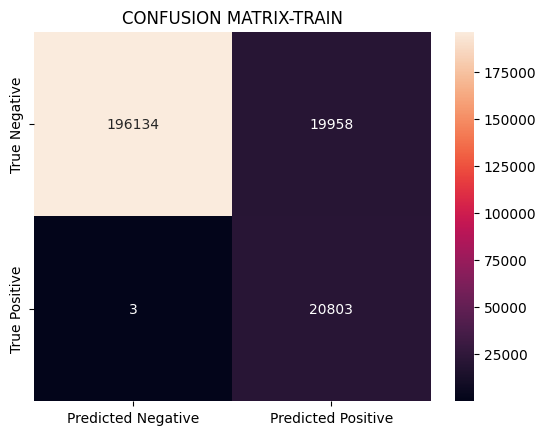

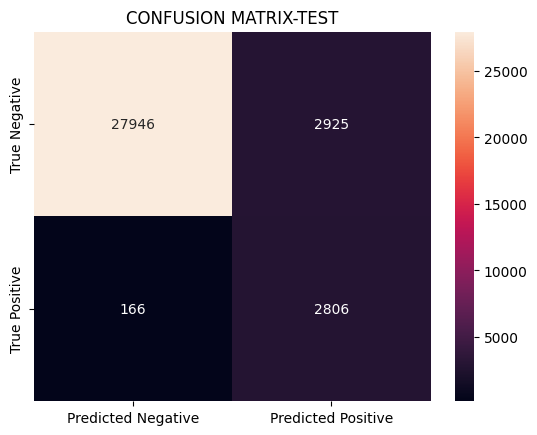

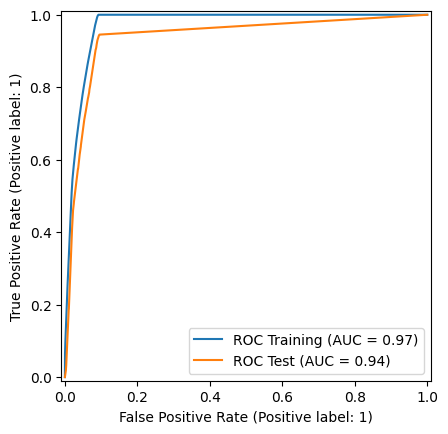

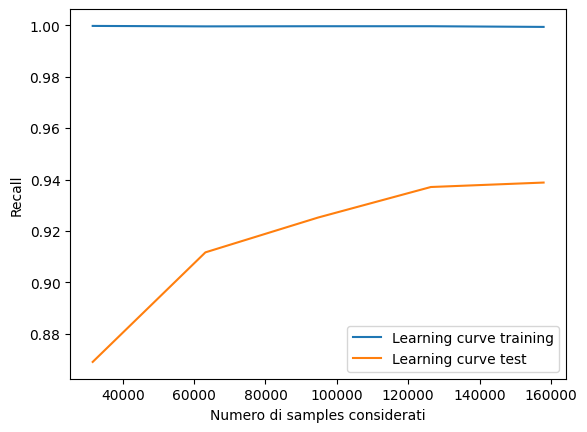

In [ ]:
############################  MAIN: MODEL  ########################

#different decision trees are tested
x_train_part=df_train.drop('TARGET', axis=1).values
y_train_part=df_train['TARGET'].values
x_val=df_val.drop('TARGET', axis=1).values
y_val=df_val['TARGET'].values


best_pars=tree_validation(x_train_part, y_train_part, x_val, y_val)


Dopo la ricerca del modello migliore, per la sua valutazione si ricorre ad opportune metriche sul train e sul test. In particolare come metrica per selezionare il modello migliore si adotta l'f1 per la sua proprietà di bilanciare precision e recall. Invece per la learning curve si opta per il recall, essendo interessante capire se il modello riesca a rintracciare tutti i veri positivi. Lo studio porta alle seguenti osservazioni:
* La log_loss ed il recall sul training indicano un modello molto performante, ad indicare anche la presenza di un certo ammontare di overfitting, confermato dal calo delle prestazioni sul set di validation, seppur restando queste a livelli accetabili.
* Osservndo metriche e matrice di confusione si nota come la pecca del modello resta la precisione, cioè si individuano troppi falsi positivi. Questo a livello di business potrebbe essere un lato non desiderabile, in quanto si concederebbe la carta di credito a clienti non affidabili, generando perdite per la banca. Per contro, il recall è molto alto, ad indicare che il modello riesce a recuperare tutti i veri positivi e a predirli correttamente.
* Dalle curve ROC del modello si può notare come il modello sia effettivamente molto più performante di un classficiatore casuale, corrispondente alla bisettrice del quadrante.
* Osservando la learning curve, si può notare come il recall su set di test cresca al crescere dei samples considerti. Per contro, la curva sul train set ancora una volta suggerisce la presenza di overfitting.

Nel seguito si testerà questo modello migliore sul set di test, andando ad applicare un aosglia di classificazione più alta, così da cercare di ridurre il numero di falsi positivi. Inoltre la presenza di overfitting è tollerata, in quanto estratta dal validatore che al suo interno ha valutato anche modelli con valori dei parametri adatti a diminuire la complessità dell'albero, e quindi l'overfitting. In tal senso, questo modello pur conservando una percentuale di overfitting, è risultato essere il migliore rispetto all'f1 sul set di validation. Si osserverà allenando su più dati (train+val nella sezione successiva) se verrà ancora mostrata la tendenza all'overfitting.


###**2.2-Performance su test set modello migliore**

Una volta identificati i valori degli iperparametri che portano al modello migliore, si passa a riallenarlo su tutto il set train+val e lo si valuta sul set di test, sempre dopo aver opportunamente codificato il dati di test secondo quando calcolato sul set di train.

Non ci sono nan rimasti fuori dalle classi di DAYS_EMPLOYED


VALUTAZIONE MODELLO MIGLIORE SU (TRAIN+VAL) E SU TEST
Log_loss_train: 0.198
Log_loss_test: 0.433

CLASSIFICATION REPORT TRAIN
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    246963
           1       0.51      0.99      0.68     23778

    accuracy                           0.92    270741
   macro avg       0.76      0.95      0.81    270741
weighted avg       0.96      0.92      0.93    270741

CLASSIFICATION REPORT TEST
              precision    recall  f1-score   support

           0       0.99      0.90      0.95     61742
           1       0.49      0.94      0.64      5944

    accuracy                           0.91     67686
   macro avg       0.74      0.92      0.79     67686
weighted avg       0.95      0.91      0.92     67686



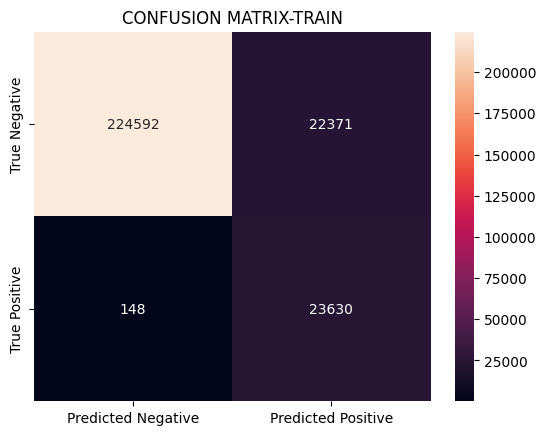

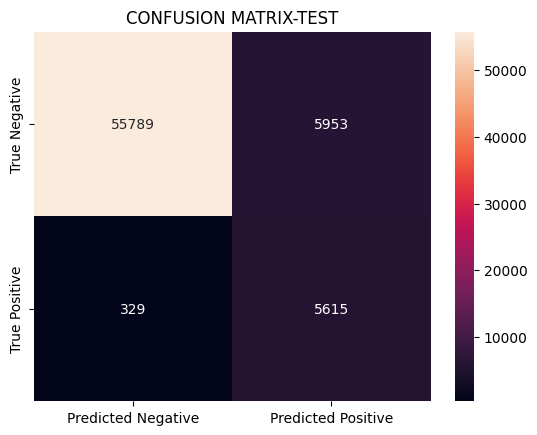

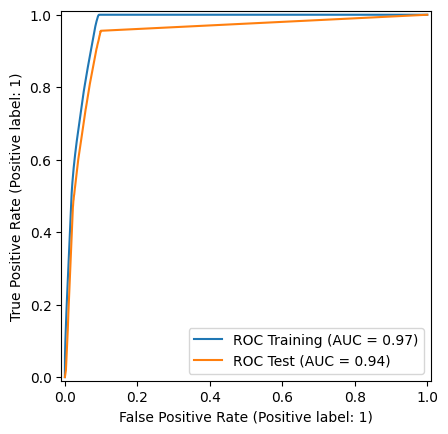

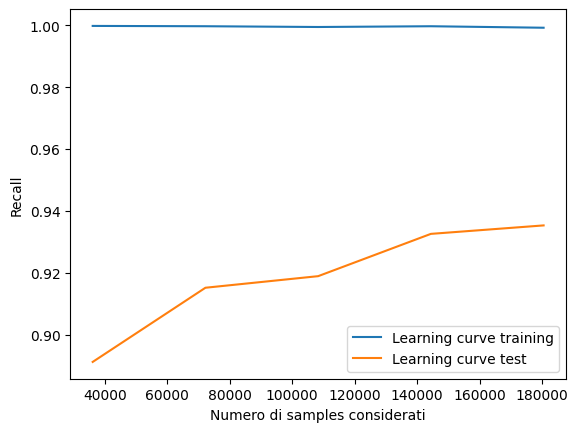

In [ ]:
# TEST SET PERFORMANCE

#best_model is trained on train+val sets and tested on test set
df_train_val=pd.concat([x_train_tot, y_train_tot], axis=1)
df_test=pd.concat([x_test, y_test], axis=1)
df_train_val, df_test=feature_engineering(df_train_val, num_var, qual_var, df_test=df_test, verbose=False, fillna=True) #preprocessing

#ohe
df_train_val=pd.get_dummies(df_train_val, columns=['CODE_GENDER','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','DAYS_EMPLOYED'])
df_test=pd.get_dummies(df_test, columns=['CODE_GENDER','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','DAYS_EMPLOYED'])

#missing columns in test set with respect to train set are filled with zero
df_test=df_test.reindex(columns=df_train_val.columns, fill_value=0)


single_tree=DecisionTreeClassifier(criterion=best_pars['criterion'],
                                  splitter='best',
                                  max_depth=best_pars['max_depth'],
                                  min_samples_split=best_pars['min_sample_split'],
                                  min_samples_leaf=best_pars['min_sample_leaf'],
                                  min_weight_fraction_leaf=0.0,
                                  max_features=None,
                                  random_state=2,
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0,
                                  class_weight='balanced', # class balance is applied
                                  ccp_alpha=best_pars['ccp'],
                                  monotonic_cst=None )

x_train=df_train_val.drop('TARGET', axis=1).values #after preprocessing, we get x_train and y_train
y_train=df_train_val['TARGET'].values

x_test=df_test.drop('TARGET', axis=1).values #after preprocessing, we get x_test and y_test
y_test=df_test['TARGET'].values

single_tree.fit(x_train, y_train)
print("\nVALUTAZIONE MODELLO MIGLIORE SU (TRAIN+VAL) E SU TEST")
evaluate_model(x_train, y_train, x_test, y_test, single_tree, thresh=0.75)



Dopo aver riallenato il modello su train+val e valutato su test, si nota come l'overfitting sia lievemente diminuito con il maggior numero di dati, restando comunque evidente visionando la learning curve. Inoltre per gestire meglio i falsi positivi, si sceglie una soglia di 0.75: oltre questa soglia si perde troppo in recall, perdendo quindi veri positivi. Tutte le altre caratteristiche sono analoghe a quelle già viste nella ricerca e valutazione del modello migliore, sezione precedente.

###**2.3-Visualizzazione qualitativa albero decisionale**

In questa breve sezione si vuole illustrare in modo qualitativo e volutamente limitato, la struttura dell'albero decisionale.

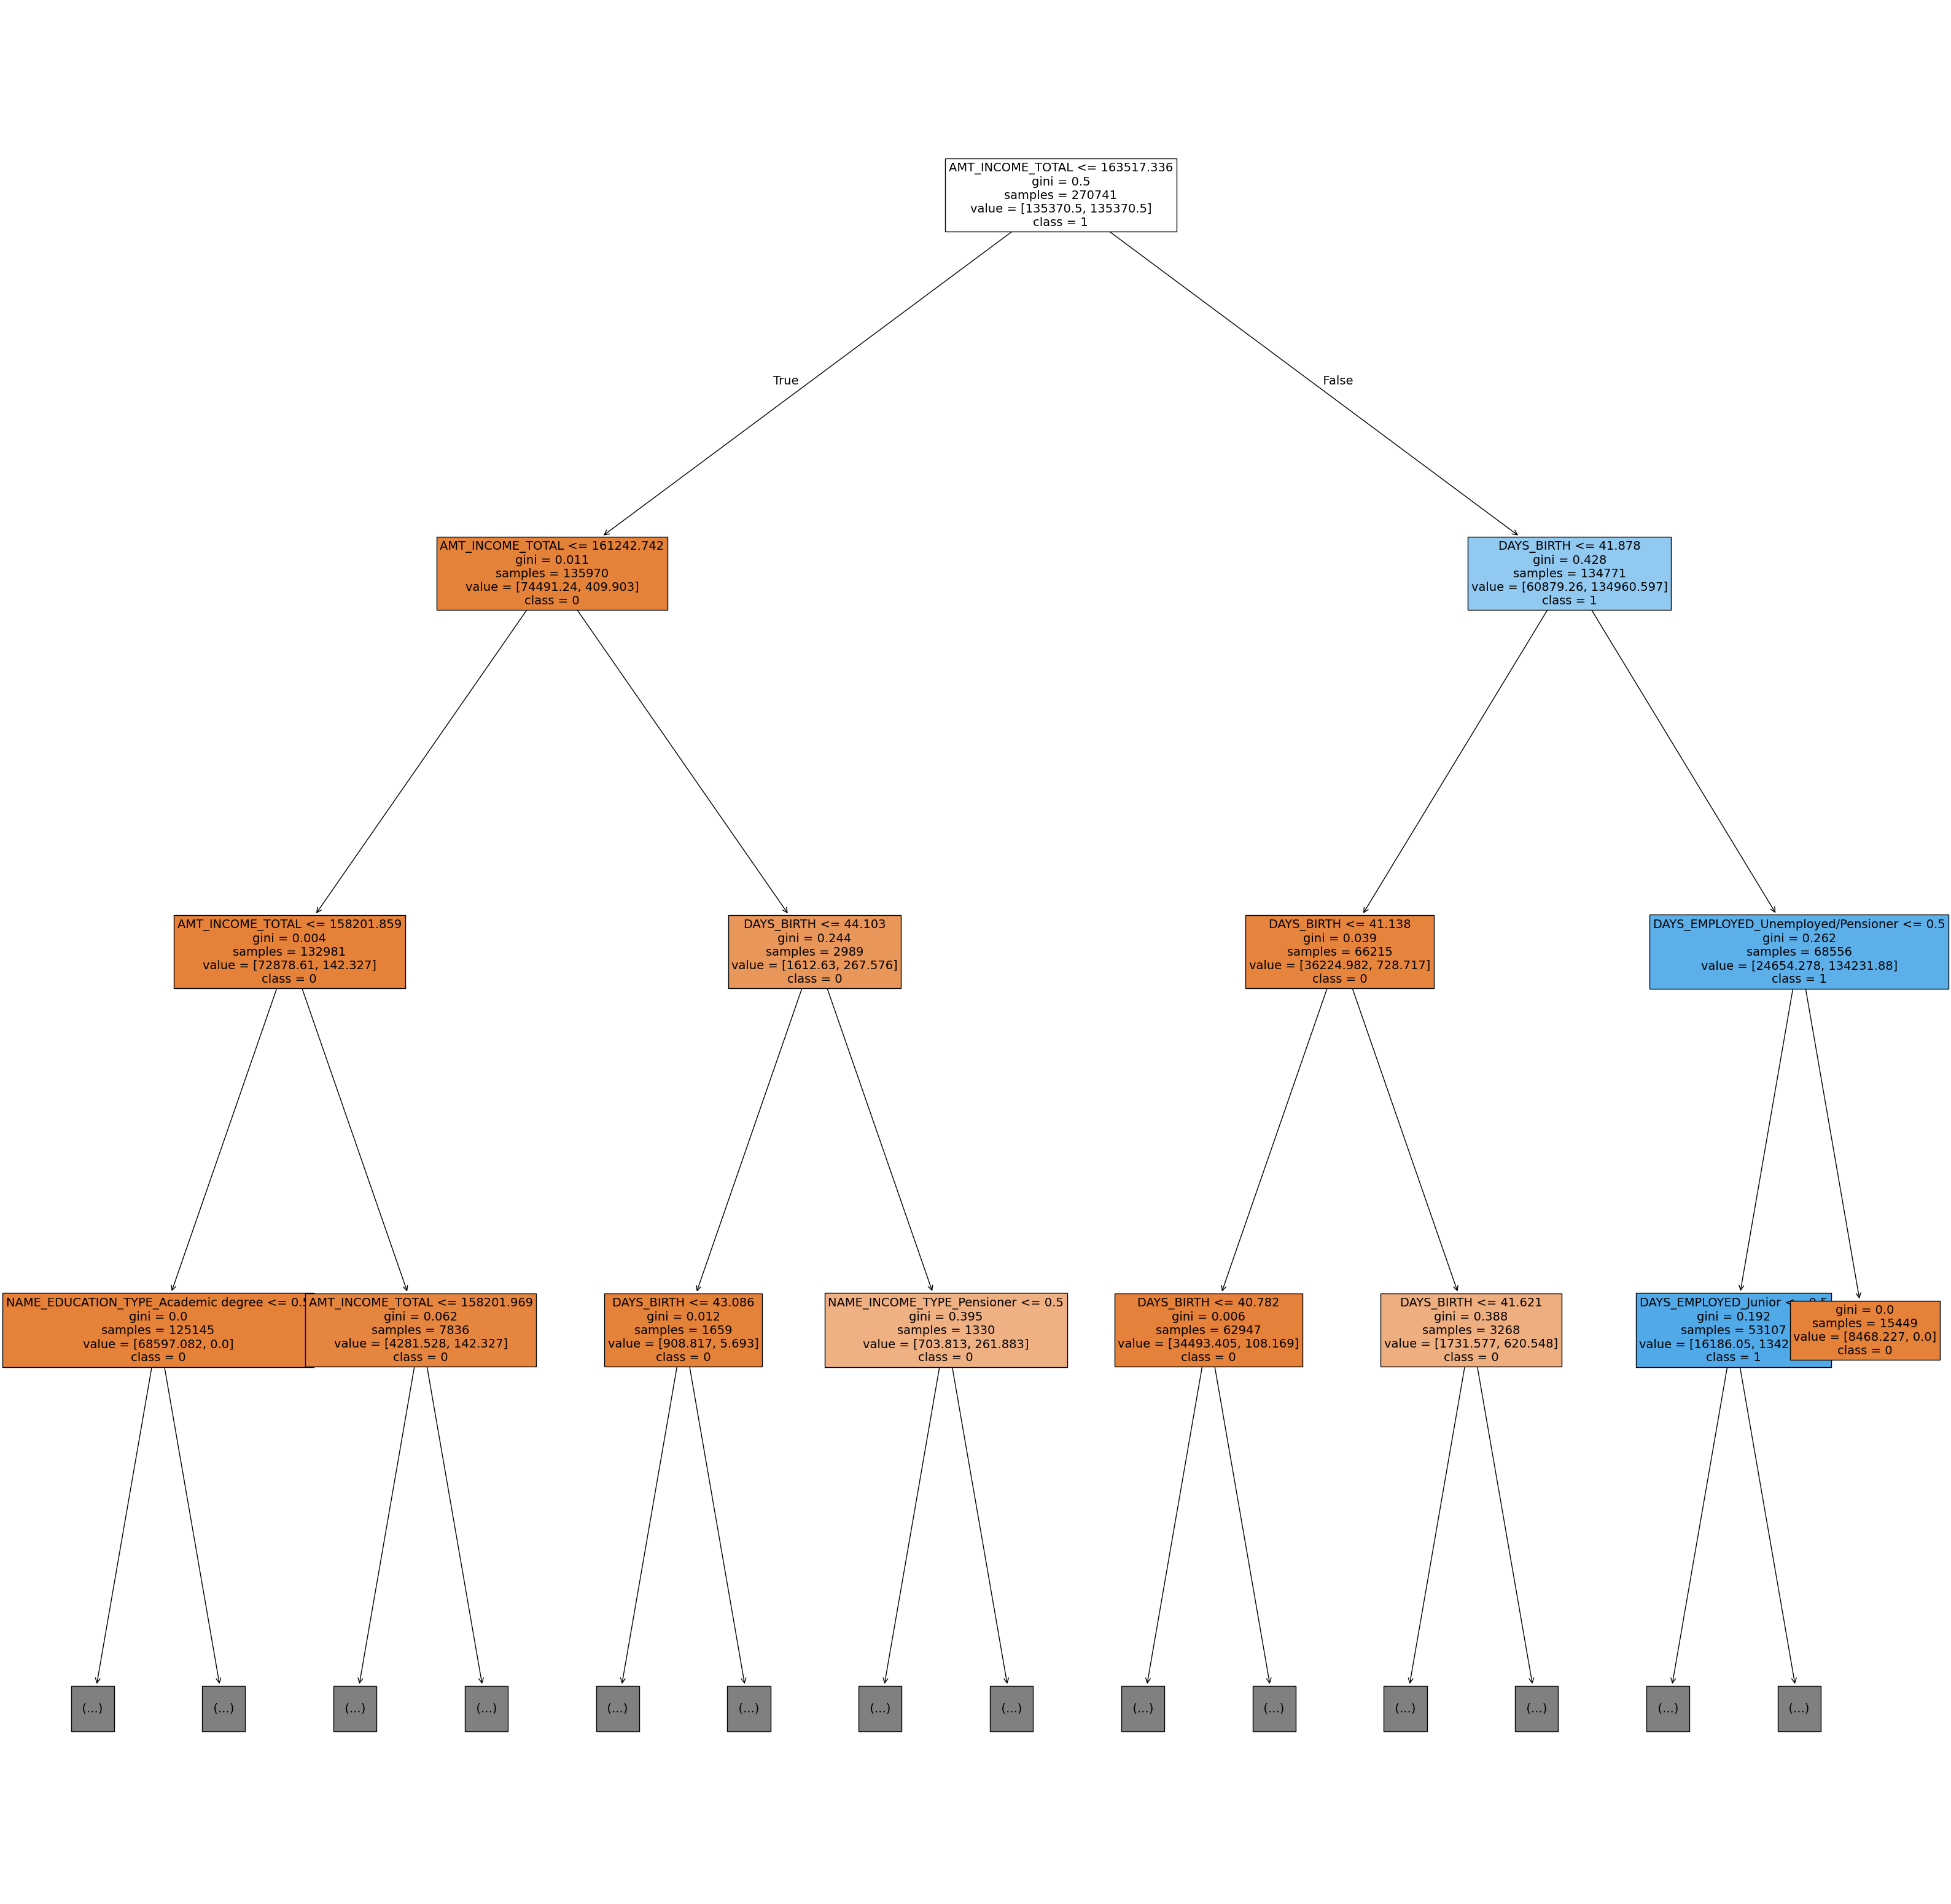

In [ ]:
#tree visualization

classes = [str(cls) for cls in single_tree.classes_] #trarget labels converted into strings for visualization
feature_names=df_train_val.drop('TARGET', axis=1).columns.tolist()

plt.figure(figsize=(40, 40))
plot_tree(single_tree, filled=True, feature_names=feature_names, class_names=classes, max_depth=3, fontsize=14)
#only partial visualization, given the high complessity
plt.show()

### **2.4-Interpretabilità risultati**

Al fine di essere in grado di fornire al cliente una giustificazione sull' avenuta/mancata concessione della carta di credito, si indaga il percorso che un dato sample fa nei vari nodi dell'albero, arrivando ad essere infine classificato nella rispettiva foglia. In tal modo si può capire per quali motivi si accetta o meno la concessione della carta.

In [ ]:
#DECISION PATH FOR A GIVEN SAMPLE

def decision_insight(model, sample, index):
    '''
    The function recovers the classification path of a given sample in the tree model.
    Args:
        - model (obj): decision tree model
        - sample (np.array): sample to classify
        - index (int): sample index in the original dataframe
    '''
    node_indicator=model.decision_path(sample.reshape(1, -1)) #nodes touched by the sample
    leaf_id=model.apply(sample.reshape(1, -1)) #index of the leaf where the sample is classified
    feature=model.tree_.feature #indices of features used in each node for classification
    threshold=model.tree_.threshold #threshold values of each node

    #print classification path
    print(f"\nPercorso decisionale per il sample {index}")
    for node_id in node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]:
        #cycle on nodes touched by the sample: if the node is not the classificiation one, print node, node feature,
        #threshold and sample value for that feature. Otherwise, print the classification result.


        if leaf_id[0]==node_id: #check if the current node classifies the sample. If yes, the probability of classificiation is evaluated
            proba_prediction=model.predict_proba(sample.reshape(1, -1))[0].max()
            print(f"Il sample è classificato come: {classes[model.predict(sample.reshape(1, -1))[0]]}, con proba: {(proba_prediction*100):.2f}%")
            break

        if sample[feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(f"Nodo {node_id}: ({feature_names[feature[node_id]]}={sample[feature[node_id]]:.3f})"+
              f"{threshold_sign} {threshold[node_id]:.3f}")


#################################################################
sample_indexes=[35,98,987,1,576]
for index in sample_indexes:
    sample=df_test.drop("TARGET", axis=1).iloc[index].values #test set samples selected
    decision_insight(single_tree, sample, index)


Percorso decisionale per il sample 35
Nodo 0: (AMT_INCOME_TOTAL=156617.650)<= 163517.336
Nodo 1: (AMT_INCOME_TOTAL=156617.650)<= 161242.742
Nodo 2: (AMT_INCOME_TOTAL=156617.650)<= 158201.859
Nodo 3: (NAME_EDUCATION_TYPE_Academic degree=0.000)<= 0.500
Il sample è classificato come: 0, con proba: 100.00%

Percorso decisionale per il sample 98
Nodo 0: (AMT_INCOME_TOTAL=215390.780)> 163517.336
Nodo 332: (DAYS_BIRTH=26.915)<= 41.878
Nodo 333: (DAYS_BIRTH=26.915)<= 41.138
Nodo 334: (DAYS_BIRTH=26.915)<= 40.782
Nodo 335: (DAYS_BIRTH=26.915)<= 40.497
Il sample è classificato come: 0, con proba: 100.00%

Percorso decisionale per il sample 987
Nodo 0: (AMT_INCOME_TOTAL=323483.870)> 163517.336
Nodo 332: (DAYS_BIRTH=54.649)> 41.878
Nodo 938: (DAYS_EMPLOYED_Unemployed/Pensioner=0.000)<= 0.500
Nodo 939: (DAYS_EMPLOYED_Junior=1.000)> 0.500
Nodo 2123: (DAYS_BIRTH=54.649)> 42.941
Nodo 2841: (DAYS_BIRTH=54.649)> 43.799
Nodo 3273: (AMT_INCOME_TOTAL=323483.870)> 164852.250
Nodo 3363: (OCCUPATION_TYPE_Coo

Dal percorso che ogni sample fa per essere classificato, si può estrarre la motivazione da dare al cliente sull'esito della sua classificazione, andando a vedere le features che più hanno influenzato la scelta. Ad esempio nel sample 35, si nota come il cliente sia classificato negativamente perchè ha un reddito inferiore alla soglia fissata dal modello e perchè non ha un grado di istruzione accademico. Invece il sample 987 viene classificato positivamente dopo un numero maggiore di passaggi nei nodi. Naturalmente dato l'elevato numero di features, è comunque complesso estrarre una motivazione semplice, chiara e concisa nella gran parte dei casi.

Si può infine notare come la probabilità con cui il modello prevede le classi sia sempre elevatissima.


### **2.5-Random Forest**

Dopo aver creato un albero decisionale, si cerca di capire se una random forest con stessi iperparametri riesca ad ottenere performance migliori, tralasciando la possibilità di interpretare in modo semplice le classificazioni ottenute.




VALUTAZIONE RANDOM FOREST SU (TRAIN+VAL) E SU TEST
Log_loss_train: 0.173
Log_loss_test: 0.196

CLASSIFICATION REPORT TRAIN
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    246963
           1       0.56      0.96      0.71     23778

    accuracy                           0.93    270741
   macro avg       0.78      0.94      0.83    270741
weighted avg       0.96      0.93      0.94    270741

CLASSIFICATION REPORT TEST
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     61742
           1       0.53      0.90      0.66      5944

    accuracy                           0.92     67686
   macro avg       0.76      0.91      0.81     67686
weighted avg       0.95      0.92      0.93     67686



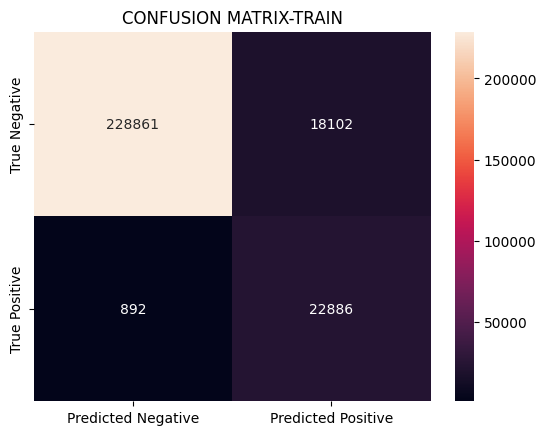

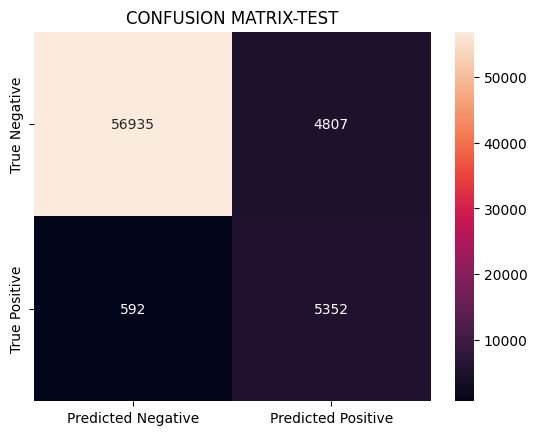

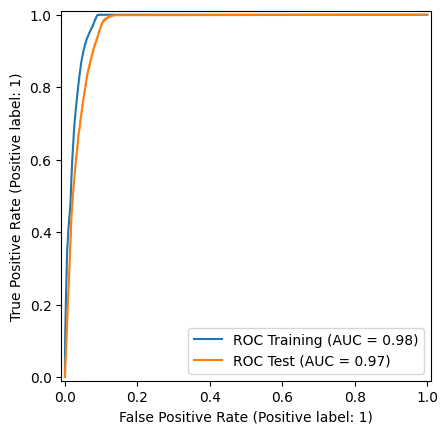

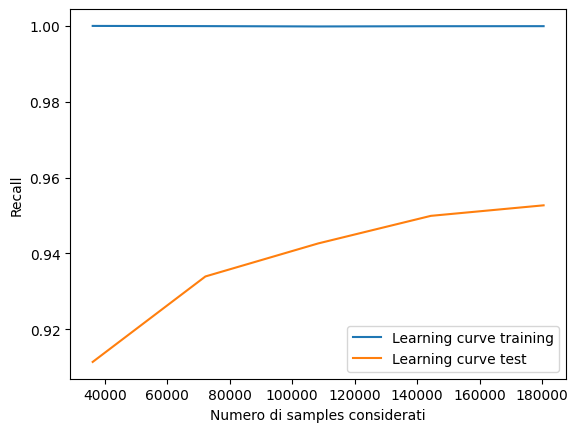

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(
    n_estimators=100,
    criterion=best_pars['criterion'],
    max_depth=best_pars['max_depth'],
    min_samples_split=best_pars['min_sample_split'],
    min_samples_leaf=best_pars['min_sample_leaf'],
    min_weight_fraction_leaf=0.0,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=2,
    verbose=0,
    warm_start=False,
    class_weight='balanced',
    ccp_alpha=best_pars['ccp'],
    max_samples=None,
    monotonic_cst=None
)


forest.fit(x_train, y_train)
print("\nVALUTAZIONE RANDOM FOREST SU (TRAIN+VAL) E SU TEST")
evaluate_model(x_train, y_train, x_test, y_test, forest, thresh=0.75)

Si può notare come i risultati della random forest siano comparabili e lievemente migliori rispetto a quelli del singolo albero, proprio grazie all'approccio mediato sui vari alberi usati. Il dato più meritevole di attenzione è proprio la log_loss che si mantiene molto bassa sia su train che su test. Lo svantaggio di tale modello è, come già accennato, la maggiore difficoltà di interpretazione.

## **Riaddestramento finale**

Al termine di tutte le analisi condotte, si riaddestra il modello ad albero su tutto il dataset, così da renderlo pronto alla messa in produzione.

In [ ]:
#preprocessing
df, _=feature_engineering(df, num_var, qual_var, df_test=None, verbose=False, fillna=True)

#ohe
df=pd.get_dummies(df, columns=['CODE_GENDER','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','DAYS_EMPLOYED'])

single_tree=DecisionTreeClassifier(criterion=best_pars['criterion'],
                                  splitter='best',
                                  max_depth=best_pars['max_depth'],
                                  min_samples_split=best_pars['min_sample_split'],
                                  min_samples_leaf=best_pars['min_sample_leaf'],
                                  min_weight_fraction_leaf=0.0,
                                  max_features=None,
                                  random_state=2,
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0,
                                  class_weight='balanced', #class balance is applied
                                  ccp_alpha=best_pars['ccp'],
                                  monotonic_cst=None )

x_train=df.drop('TARGET', axis=1).values #preprocessed x_train and y_train
y_train=df['TARGET'].values

single_tree.fit(x_train, y_train) #fit on the whole dataset

Non ci sono nan rimasti fuori dalle classi di DAYS_EMPLOYED



DecisionTreeClassifier(class_weight='balanced', max_depth=20, random_state=2)